# Видео 2

Проверим гипотезу: возможно ли попасть в цель, стреляя навесом из винтовки Мосина. И если да, то какие ограничения существуют.

То есть, рассматривая пулю как материальную точку и учитывая её вес и силу сопротивления ветра, нужно решить следующие задачи:
- Найти $\alpha$ (начальный угол навеса), который необходим для попадания в цель. Вывести значение в градусах.
- Определить, какой максимальной высоты при этом угле достигнет пуля. Вывести значение.
- Построить график $y(x)$, $F_c(t)$.


Необходимо решить задачу двумя способами: когда учитывается и не учитывается сопротивление воздуха и когда $F_c(v^2)=-kv \vec{v}$. Вторая задача может быть решена только с помощью численного интегрирования.

Так как мы проверяем винтовку Мосина, то все технические характеристики, такие как вес пули $m$, скорость пули на вылете $v_0$, эффективное расстояние для стрельбы, взяты из официальной документации.

$m=13,6\ г, L=1500\ м, k=1,3 \cdot 10^{-5}, v_0=870\ м/с$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# --- Параметры задачи -------------------
m = 0.0136      # Масса пули, кг
v0 = 870.0      # Начальная скорость, м/с
L = 1500.0      # Дистанция до цели, м
k = 1.3e-5      # Коэффициент сопротивления, кг/м
g = 9.81        # Ускорение свободного падения, м/с^2

# ЧАСТЬ 1: РЕШЕНИЕ В ВАКУУМЕ (АНАЛИТИЧЕСКОЕ)------------------------------------------------------------------------------------------------------------------------------

def solve_vacuum():
    """Решает задачу для случая без сопротивления воздуха."""
    print("--- 1. Результаты для стрельбы в вакууме ---")

    val = g * L / v0**2
    if val > 1.0:
        print("В вакууме цель недостижима на данной дистанции.")
        return None, None

    alpha_rad_high = (np.pi - np.arcsin(val)) / 2.0
    alpha_deg_high = np.rad2deg(alpha_rad_high)

    h_max = (v0 * np.sin(alpha_rad_high))**2 / (2 * g)

    print(f"Угол стрельбы навесом: {alpha_deg_high:.1f} градусов")
    print(f"Максимальная высота полета: {h_max / 1000:.1f} км")

    x_traj = np.linspace(0, L, 500)
    y_traj = x_traj * np.tan(alpha_rad_high) - (g / (2 * v0**2 * np.cos(alpha_rad_high)**2)) * x_traj**2

    return x_traj, y_traj, "В вакууме"

# ЧАСТЬ 2: РЕШЕНИЕ С СОПРОТИВЛЕНИЕМ ВОЗДУХА (ЧИСЛЕННОЕ)--------------------------------------------------------------------------------------------------------

def calculate_trajectory_with_drag(alpha_deg):
    """
    Выполняет численное интегрирование для нахождения траектории
    и возвращает дальность полета, макс. высоту и данные для графиков.
    """
    alpha_rad = np.deg2rad(alpha_deg)

    x, y = 0.0, 0.0
    vx = v0 * np.cos(alpha_rad)
    vy = v0 * np.sin(alpha_rad)
    dt = 0.01

    t_vals, x_vals, y_vals, vx_vals, vy_vals = [0], [x], [y], [vx], [vy]
    h_max = 0.0

    while y >= 0:
        v = np.sqrt(vx**2 + vy**2)
        Fx = -k * v * vx
        Fy = -k * v * vy

        ax = Fx / m
        ay = -g + (Fy / m)

        vx += ax * dt
        vy += ay * dt
        x += vx * dt
        y += vy * dt

        t_vals.append(t_vals[-1] + dt)
        x_vals.append(x)
        y_vals.append(y)
        vx_vals.append(vx)
        vy_vals.append(vy)

        if y > h_max:
            h_max = y

    return x, h_max, (np.array(t_vals), np.array(x_vals), np.array(y_vals), np.array(vx_vals), np.array(vy_vals))


def solve_drag():
    """Находит угол и строит графики для случая с сопротивлением воздуха."""
    print("\n--- 2. Результаты с учетом сопротивления воздуха ---")

    objective_func = lambda angle: calculate_trajectory_with_drag(angle)[0] - L

    try:
        alpha_final_deg = brentq(objective_func, 1, 89)
    except ValueError:
        print("Не удалось найти угол для попадания в цель.")
        return None # Возвращаем None в случае неудачи

    final_range, h_max, traj_data = calculate_trajectory_with_drag(alpha_final_deg)
    t, x, y, vx, vy = traj_data

    print(f"Угол стрельбы навесом: {alpha_final_deg:.1f} градусов")
    print(f"Максимальная высота полета: {h_max:.0f} м")

    v_abs = np.sqrt(vx**2 + vy**2)
    Fc = k * v_abs**2

    return x, y, t, Fc, "С учетом воздуха"


# --- Основной блок вычисления -----------------------------------------------------------------------------------------------------------------
# Решаем и получаем данные для графиков
x1, y1, label1 = solve_vacuum()

# Инициализируем переменные для второго случая значением None
x2, y2, t2, Fc2, label2 = None, None, None, None, None

# Пытаемся их вычислить
result = solve_drag()
if result is not None:
    # Если получилось, перезаписываем переменные
    x2, y2, t2, Fc2, label2 = result
else:
    # Если нет, выводим сообщение
    print("Построение только траектории в вакууме.")


# --- Построение графиков -----------------------------------------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
fig.suptitle('Анализ траектории пули винтовки Мосина на дистанции 1500 м', fontsize=16)

# График 1: Траектории y(x)
# График для вакуума строится всегда
ax1.plot(x1 / 1000, y1 / 1000, label=label1, lw=2, color='royalblue')

# График для воздуха строится, только если есть данные
if x2 is not None:
    ax1.plot(x2 / 1000, y2 / 1000, label=label2, lw=2, color='orangered')

ax1.set_title('График траектории y(x)', fontsize=14)
ax1.set_xlabel('Дальность (км)', fontsize=12)
ax1.set_ylabel('Высота (км)', fontsize=12)
ax1.legend()
ax1.axis('equal')
ax1.grid(True)

# График 2: Сила сопротивления Fc(t)
# Строится, только если есть данные
if t2 is not None:
    ax2.plot(t2, Fc2, label='Сила сопротивления', color='darkviolet', lw=2)
    ax2.set_title('Сила сопротивления воздуха F_c(t)', fontsize=14)
    ax2.set_xlabel('Время полета (с)', fontsize=12)
    ax2.set_ylabel('Сила (Н)', fontsize=12)
    ax2.legend()
    ax2.grid(True)
else:
    # Если данных нет, показываем информативный текст
    ax2.text(0.5, 0.5, 'Нет данных для сопротивления воздуха',
             ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

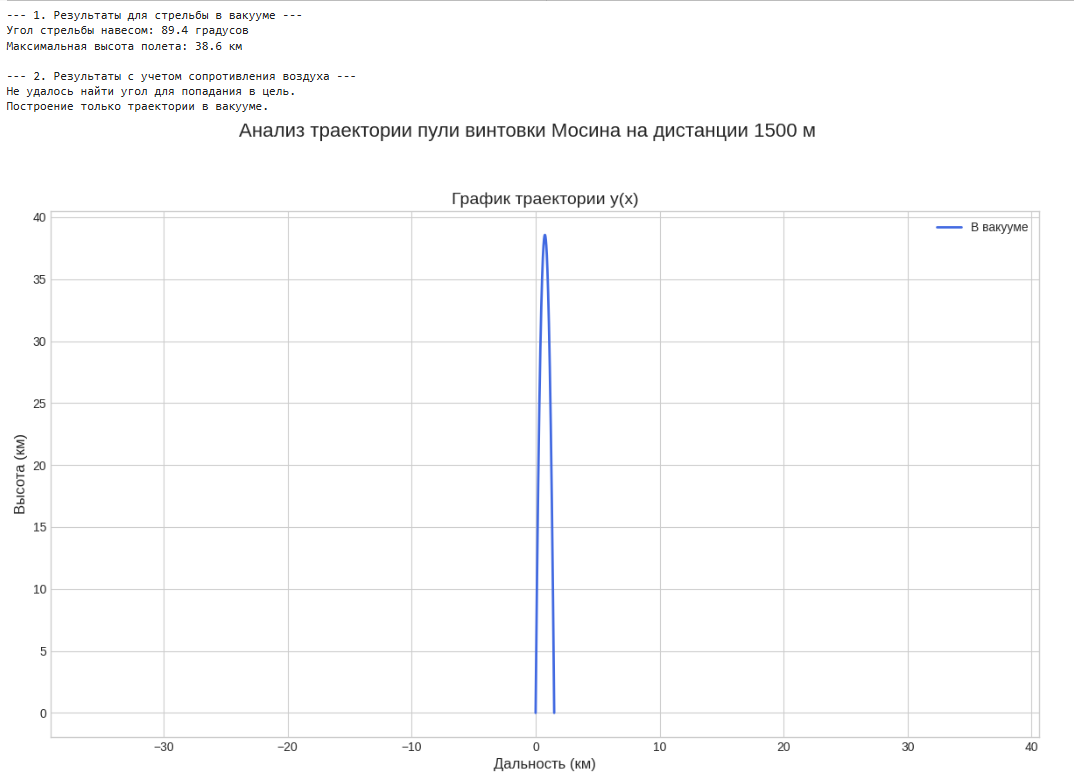
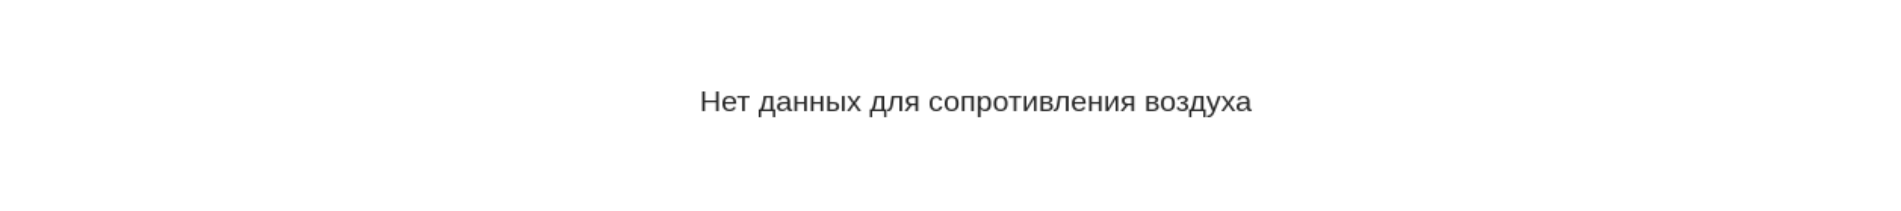

# Видео 3

## Задача 1

Груз $A$ весом $P$ спускается по боковой грани призмы $B$, расположенной под углом $\alpha$ к горизонту.

Призма движется по гладкой горизонтальной плоскости направо с ускорением $a$.

Определите $x(t)$ груза по отношению к призме и его давление на её боковую грань, если коэффициент трения скольжения груза о грань призмы равен $f$.

Решите аналитически.

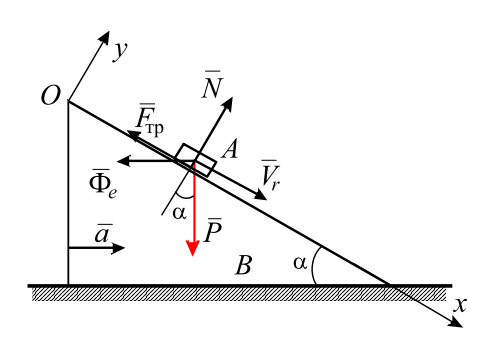

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Входные параметры и константы -------------------------------------------------------------------------------------------------------------------------------------------------
g = 9.81  # Ускорение свободного падения, м/с²

# Параметры задачи (можно изменять)
P = 10.0      # Вес груза A, Н
alpha_deg = 30 # Угол наклона грани призмы, градусы
f = 0.2       # Коэффициент трения скольжения
a = 2.0       # Ускорение призмы B, м/с²

# --- 2. Основные расчеты -------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_dynamics(P, alpha_deg, f, a, g):
    """
    Рассчитывает ключевые динамические характеристики системы.
    Работа ведется в неинерциальной системе отсчета, связанной с призмой.
    """
    # Перевод в радианы и расчет массы
    alpha_rad = np.radians(alpha_deg)
    m = P / g

    # Сила нормальной реакции (N)
    # N уравновешивает компоненты силы тяжести и силы инерции, перпендикулярные плоскости.
    # Сила инерции F_in = m*a, ее компонента, прижимающая к плоскости, равна m*a*sin(α)
    N = m * g * np.cos(alpha_rad) + m * a * np.sin(alpha_rad)

    # Сила трения (F_friction)
    F_friction = f * N

    # Движущая сила (F_drive)
    # Складывается из компонент силы тяжести и силы инерции, направленных вдоль плоскости.
    F_drive = m * g * np.sin(alpha_rad) + m * a * np.cos(alpha_rad)

    # Условие движения и относительное ускорение (a_rel)
    if F_drive <= F_friction:
        # Если движущая сила меньше или равна силе трения покоя, груз не движется.
        a_rel = 0.0
        direction = "остается неподвижным"
    else:
        # Иначе груз скользит вниз, и ускорение равно (Движущая сила - Сила трения) / масса
        # Ускорение будет отрицательным, так как направлено вниз по плоскости
        a_rel = (F_friction - F_drive) / m
        direction = "вниз по наклонной плоскости"

    return {
        "m": m,
        "alpha_rad": alpha_rad,
        "N": N,
        "F_friction": F_friction,
        "F_drive": F_drive,
        "a_rel": a_rel,
        "direction": direction
    }

# --- 3. Анализ энергии по теореме об изменении кинетической энергии -----------------------------------------------------------------------------------------------------------------------
def analyze_energy(results, t_check):
    """
    Проверяет выполнение теоремы об изменении кинетической энергии.
    ΔK_rel = W_net (в неинерциальной системе отсчета)
    """
    m = results["m"]
    a_rel = results["a_rel"]
    alpha_rad = results["alpha_rad"]

    # Кинематика в момент времени t_check
    # Перемещение s будет отрицательным, т.к. a_rel <= 0
    s_rel = 0.5 * a_rel * t_check**2
    v_rel = a_rel * t_check

    # Изменение кинетической энергии (относительной)
    delta_K_rel = 0.5 * m * v_rel**2

    # Работа всех сил при относительном перемещении s_rel
    # Работа сил, направленных вниз по склону (тяжести, инерции), положительна, т.к. s_rel < 0
    W_gravity = (m * g * np.sin(alpha_rad)) * abs(s_rel)
    W_inertial = (m * a * np.cos(alpha_rad)) * abs(s_rel)
    W_friction = -results["F_friction"] * abs(s_rel) # Сила трения направлена против движения

    W_net = W_gravity + W_inertial + W_friction

    return {
        "t_check": t_check,
        "s_rel": s_rel,
        "v_rel": v_rel,
        "delta_K_rel": delta_K_rel,
        "W_net": W_net
    }

# --- 4. Визуализация --------------------------------------------------------------------------------------------------------------------------------------------------------
def create_plots(results, t):
    """
    Создает и отображает графики движения и диаграмму сил.
    """
    a_rel = results["a_rel"]
    N = results["N"]
    m = results["m"]
    alpha_rad = results["alpha_rad"]

    # Расчет траекторий (используем векторизацию numpy, без циклов)
    x_rel = 0.5 * a_rel * t**2
    v_rel = a_rel * t

    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(14, 7))

    # --- График 4.1: Диаграмма сил ------------------------------------------------------------------------------------------------------------------------------------------
    ax1 = fig.add_subplot(1, 2, 1)
    prism_x = [0, 2, 0, 0]
    prism_y = [0, 0, 2 * np.tan(alpha_rad), 0]
    ax1.plot(prism_x, prism_y, 'k-', label='Призма B')

    # Положение груза
    block_pos_x, block_pos_y = 1, np.tan(alpha_rad)
    ax1.add_patch(plt.Rectangle((block_pos_x - 0.1, block_pos_y - 0.1), 0.2, 0.2, color='deepskyblue', label='Груз A'))

    # Векторы сил (масштабируем для наглядности)
    scale = 0.4
    # Сила тяжести P=mg (вертикально вниз)
    ax1.arrow(block_pos_x, block_pos_y, 0, -m*g*scale, head_width=0.05, color='r', label=f'P (Сила тяжести)')
    # Сила инерции F_in (горизонтально, против ускорения 'a')
    ax1.arrow(block_pos_x, block_pos_y, -m*a*scale, 0, head_width=0.05, color='purple', label=f'F_инерц')
    # Сила нормальной реакции N (перпендикулярно плоскости)
    ax1.arrow(block_pos_x, block_pos_y, -N*np.sin(alpha_rad)*scale, N*np.cos(alpha_rad)*scale, head_width=0.05, color='g', label=f'N (Реакция опоры)')
    # Сила трения F_тр (вдоль плоскости, против движения)
    if a_rel != 0:
      ax1.arrow(block_pos_x, block_pos_y, results['F_friction']*np.cos(alpha_rad)*scale, results['F_friction']*np.sin(alpha_rad)*scale, head_width=0.05, color='orange', label=f'F_тр (Трение)')

    ax1.set_title('Диаграмма сил в системе отсчета призмы', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.grid(True)
    ax1.legend()
    ax1.axis('equal')

    # --- Графики 4.2 и 4.3: Закон движения и скорость -----------------------------------------------------------------------------------------------------------------------
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(t, x_rel, 'b-', label=f'x(t), a_отн = {a_rel:.3f} м/с²')
    ax2.set_title('Закон движения (относительного)')
    ax2.set_ylabel('Координата x, м')
    ax2.legend()

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(t, v_rel, 'g-')
    ax3.set_title('Скорость (относительная)')
    ax3.set_xlabel('Время t, с')
    ax3.set_ylabel('Скорость v, м/с')

    plt.tight_layout()
    plt.show()

# --- 5. main ---------------------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    # Выполняем расчеты динамики
    dyn_results = calculate_dynamics(P, alpha_deg, f, a, g)

    # Выводим основные результаты расчетов
    print("--- Результаты расчета динамики ---")
    print(f"Масса груза m = {dyn_results['m']:.3f} кг")
    print(f"Сила нормальной реакции N = {dyn_results['N']:.3f} Н")
    print(f"Движущая сила (вдоль склона) F_drive = {dyn_results['F_drive']:.3f} Н")
    print(f"Сила трения скольжения F_friction = {dyn_results['F_friction']:.3f} Н")
    print("-" * 20)
    print(f"Относительное ускорение a_отн = {dyn_results['a_rel']:.3f} м/с²")
    print(f"Направление движения груза: {dyn_results['direction']}")
    print("-" * 20)

    # Анализ по теореме об изменении кинетической энергии
    t_check = 2.5 # Момент времени для проверки
    energy_analysis = analyze_energy(dyn_results, t_check)

    print(f"\n--- Анализ по теореме об изменении кинетической энергии (t = {t_check} c) ---")
    print(f"Относительное перемещение s_отн = {energy_analysis['s_rel']:.3f} м")
    print(f"Относительная скорость v_отн = {energy_analysis['v_rel']:.3f} м/с")
    print("-" * 20)
    print(f"Изменение кин. энергии ΔK_отн = {energy_analysis['delta_K_rel']:.3f} Дж")
    print(f"Суммарная работа всех сил W_net = {energy_analysis['W_net']:.3f} Дж")
    if np.isclose(energy_analysis['delta_K_rel'], energy_analysis['W_net']):
        print(" Теорема выполняется: ΔK_отн ≈ W_net")
    else:
        print(" Ошибка: Теорема не выполняется!")

    # Временной интервал для графиков
    t_space = np.linspace(0, 5, 500)
    # Построение графиков
    create_plots(dyn_results, t_space)

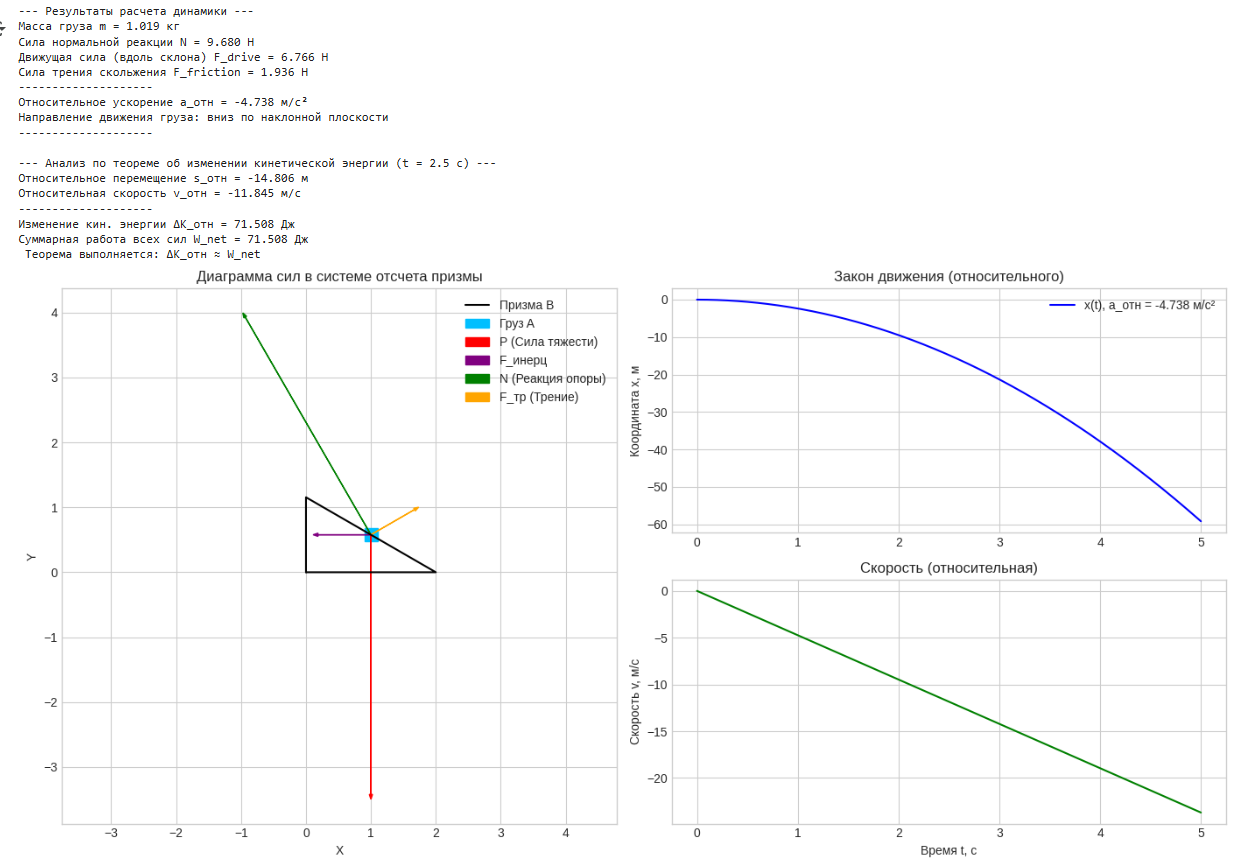

# Видео 5

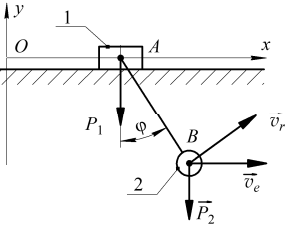

Найдите уравнение движения механизма (эллиптический маятник inverted pendulum on a cart) в общем виде, используя метод **Ньютона — Эйлера**. Известны массы $m_{1,2}$. Трение отсутствует. Тело $B$ рассматривайте как математический маятник.

Результат представьте в виде пары формул $(\ddot{\phi}, \ddot{x})$.


*Подсказка:*


``` python
from sympy.physics.mechanics import init_vprinting
init_vprinting()
```
Позволит выводить формулы в читаемом виде (не $\frac{dx}{dt}$, а $\dot{x}$). Также это позволит более успешно дифференцировать (но иногда необходимо результат обрабатывать `sp.simplify`, `sp.expand`).



In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. символьное решение -------------------------------------------------------------------------------------

# Объявление символов
t = sp.Symbol('t')
m1, m2, l, g, P1, P2 = sp.symbols('m1 m2 l g P1 P2')
x = sp.Function('x')(t)
phi = sp.Function('phi')(t)

# Производные
xdot = x.diff(t)
phidot = phi.diff(t)
xddot = x.diff(t, 2)
phiddot = phi.diff(t, 2)

print("АНАЛИЗ ЗАДАЧИ: ЭЛЛИПТИЧЕСКИЙ МАЯТНИК НА ТЕЛЕЖКЕ")

# Кинетическая энергия (T)
T1 = 0.5 * m1 * xdot**2
vx_m = xdot + l * phidot * sp.cos(phi)
vy_m = l * phidot * sp.sin(phi)
T2 = 0.5 * m2 * (vx_m**2 + vy_m**2)
T = sp.simplify(T1 + T2)

# Потенциальная энергия (V)
V = m2 * g * l * (1 - sp.cos(phi)) # Зададим ноль потенциальной энергии в нижнем положении

# Лагранжиан (L)
L = T - V

# Уравнения Лагранжа
eq1 = sp.Eq(sp.diff(sp.diff(L, xdot), t) - sp.diff(L, x), P1)
eq2 = sp.Eq(sp.diff(sp.diff(L, phidot), t) - sp.diff(L, phi), P2)

# Решаем систему уравнений относительно вторых производных
solution = sp.solve([eq1, eq2], (xddot, phiddot))
xddot_expr = sp.simplify(solution[xddot])
phiddot_expr = sp.simplify(solution[phiddot])

print("УРАВНЕНИЯ ДВИЖЕНИЯ (решённые относительно ẍ и φ̈):")
print("\nУскорение тележки (ẍ):")
sp.pprint(xddot_expr, use_unicode=True)
print("\nУгловое ускорение маятника (φ̈):")
sp.pprint(phiddot_expr, use_unicode=True)


# --- 2. численное решение  -----------------------------------------------------------------------------------------------------------------

# Задаем конкретные параметры
params = {
    m1: 1.0,   # масса тележки, кг
    m2: 0.5,   # масса маятника, кг
    l: 1.0,    # длина стержня, м
    g: 9.81,   # ускорение свободного падения, м/с²
    P1: 0.0,   # сила на тележку
    P2: 0.0    # сила на маятник (например, момент)
}

print("ПАРАМЕТРЫ ДЛЯ ЧИСЛЕННОГО РЕШЕНИЯ:")
for key, value in params.items():
    print(f"{key} = {value}")
print()

# Используем lambdify для преобразования символьных выражений в быстрые числовые функции
# Это современный и безопасный способ "оживить" уравнения
vars_for_lambdify = [x, xdot, phi, phidot, m1, m2, l, g, P1, P2]
xddot_func = sp.lambdify(vars_for_lambdify, xddot_expr.subs(params), 'numpy')
phiddot_func = sp.lambdify(vars_for_lambdify, phiddot_expr.subs(params), 'numpy')

def equations_of_motion(t, state):
    """
    Система дифференциальных уравнений движения.
    state = [x, x_dot, phi, phi_dot]
    """
    x_val, x_dot_val, phi_val, phi_dot_val = state

    # Вычисляем ускорения с помощью "оживлённых" функций
    # Передаем только те переменные, которые не были подставлены через .subs(params)
    # В нашем случае подставлены все, поэтому передаем фиктивные значения
    args = [x_val, x_dot_val, phi_val, phi_dot_val, 0, 0, 0, 0, 0, 0]

    x_ddot = xddot_func(*args)
    phi_ddot = phiddot_func(*args)

    return [x_dot_val, x_ddot, phi_dot_val, phi_ddot]

# Начальные условия
initial_state = [
    0.0,        # начальная позиция тележки
    0.0,        # начальная скорость тележки
    np.pi / 4,  # начальный угол (45 градусов)
    0.0         # начальная угловая скорость
]

print(f"НАЧАЛЬНЫЕ УСЛОВИЯ:")
print(f"x(0) = {initial_state[0]} м, ẋ(0) = {initial_state[1]} м/с")
print(f"φ(0) = {initial_state[2]:.2f} рад, φ̇(0) = {initial_state[3]} рад/с\n")

# Временной интервал и решение системы ОДУ
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)
solution = solve_ivp(
    equations_of_motion, t_span, initial_state,
    t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-8
)

# Извлечение результатов
t_sol = solution.t
x_sol, x_dot_sol, phi_sol, phi_dot_sol = solution.y

# --- 3. построение графиков и выводы ----------------------------------------------------------------------------------------

# Графики
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t_sol, x_sol, 'b-', label='x(t) - тележка')
ax1.plot(t_sol, phi_sol, 'g-', label='φ(t) - маятник')
ax1.set_title('Координаты системы')
ax1.set_xlabel('Время t, с')
ax1.set_ylabel('Координата x, м / Угол φ, рад')
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t_sol, x_dot_sol, 'r-', label='ẋ(t) - скорость тележки')
ax2.plot(t_sol, phi_dot_sol, 'm-', label='φ̇(t) - скорость маятника')
ax2.set_title('Скорости системы')
ax2.set_xlabel('Время t, с')
ax2.set_ylabel('Скорость, м/с или рад/с')
ax2.legend()
ax2.grid(True)

ax3 = fig.add_subplot(gs[1, :])
# Анализ энергии системы
T_sol = 0.5*params[m1]*x_dot_sol**2 + 0.5*params[m2]*( (x_dot_sol + params[l]*phi_dot_sol*np.cos(phi_sol))**2 + (params[l]*phi_dot_sol*np.sin(phi_sol))**2 )
V_sol = params[m2]*params[g]*params[l]*(1 - np.cos(phi_sol))
E_total = T_sol + V_sol

ax3.plot(t_sol, T_sol, 'b--', label='Кинетическая энергия T')
ax3.plot(t_sol, V_sol, 'r--', label='Потенциальная энергия V')
ax3.plot(t_sol, E_total, 'k-', linewidth=2, label='Полная энергия E = T + V')
ax3.set_title('Анализ энергии системы')
ax3.set_xlabel('Время t, с')
ax3.set_ylabel('Энергия, Дж')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Проверка сохранения энергии
energy_variation = np.max(E_total) - np.min(E_total)
print(f"\nАНАЛИЗ СОХРАНЕНИЯ ЭНЕРГИИ:")
print(f"Абсолютное изменение полной энергии за время симуляции: {energy_variation:.3e} Дж")
if np.mean(E_total) != 0:
    relative_variation = energy_variation / np.mean(E_total)
    print(f"Относительное изменение полной энергии: {relative_variation:.3e} ({relative_variation*100:.6f}%)")
    if relative_variation < 1e-6: # Допуск для решателя RK45 с rtol=1e-8
        print("Энергия сохраняется с высокой точностью. Численное решение корректно.")
    else:
        print("Обнаружено заметное изменение энергии. Проверьте параметры решателя или уравнения.")

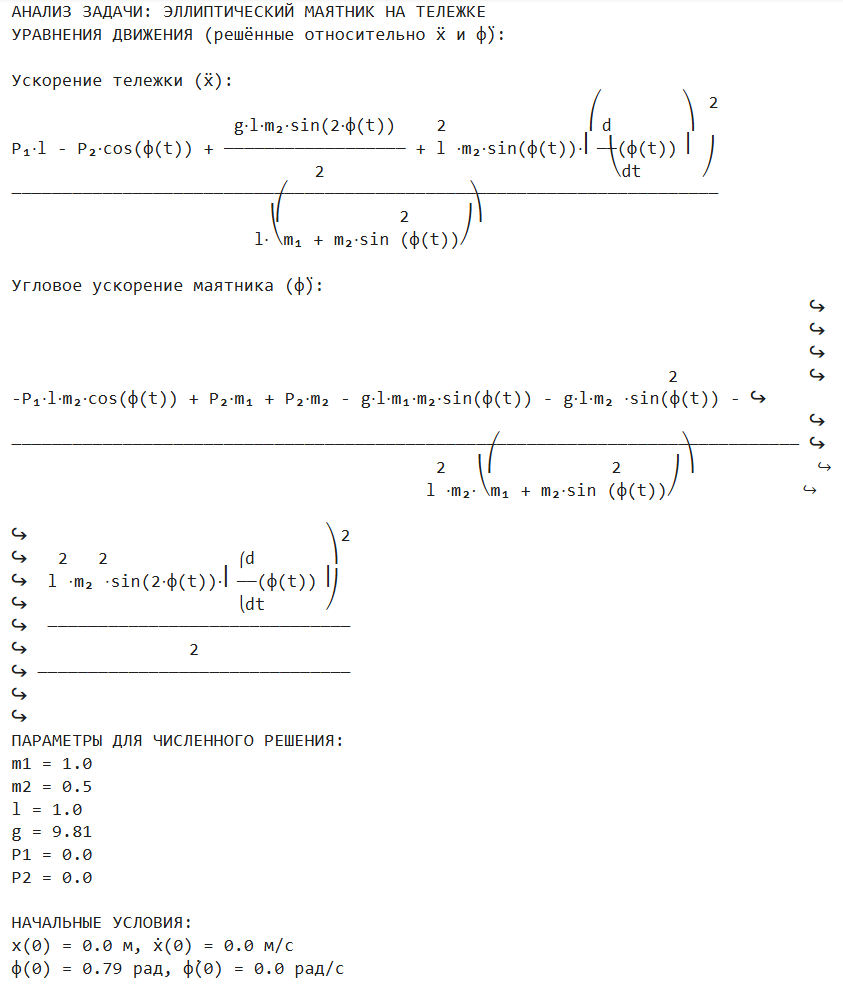
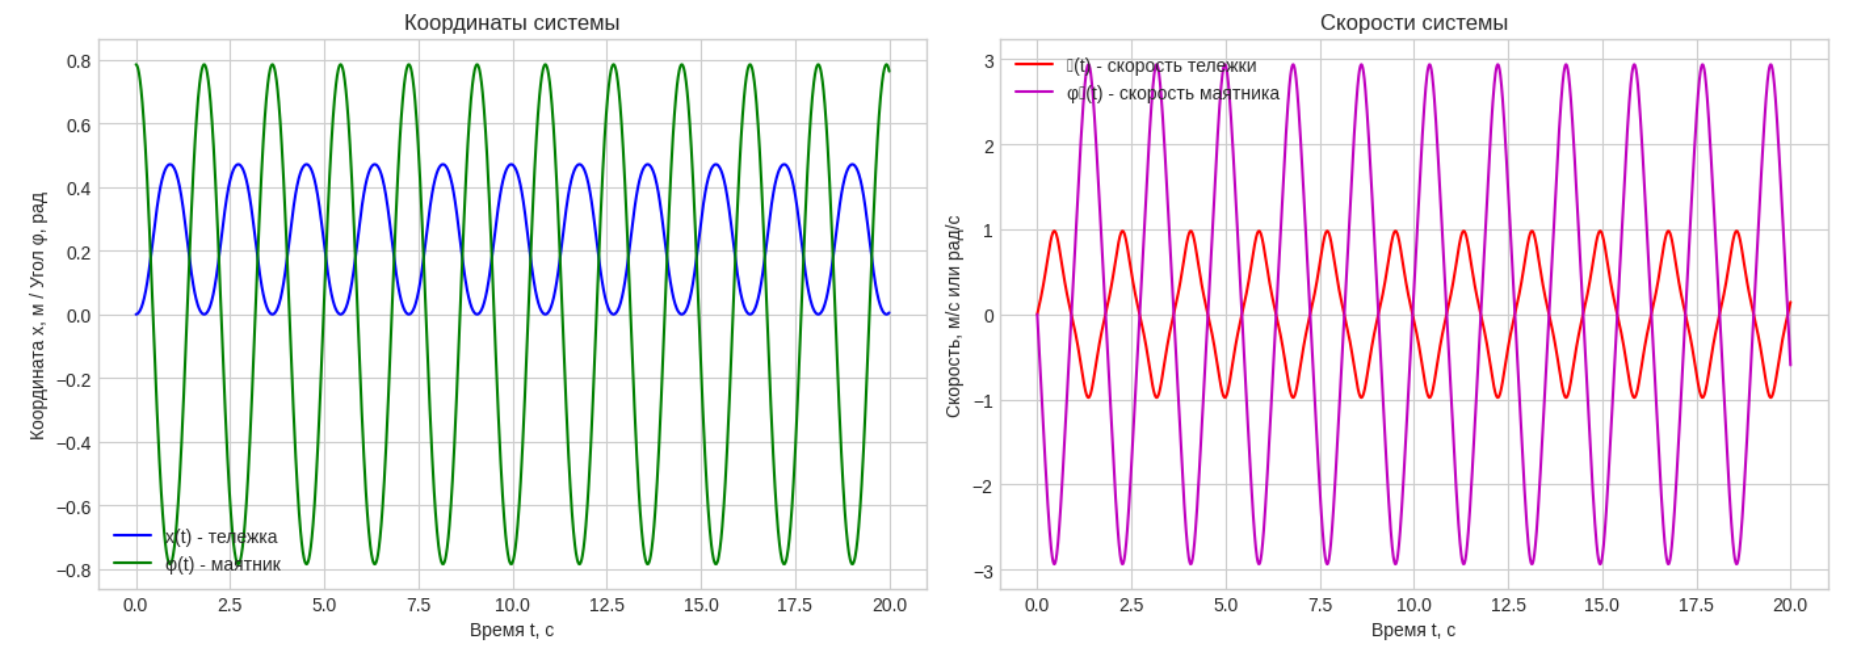
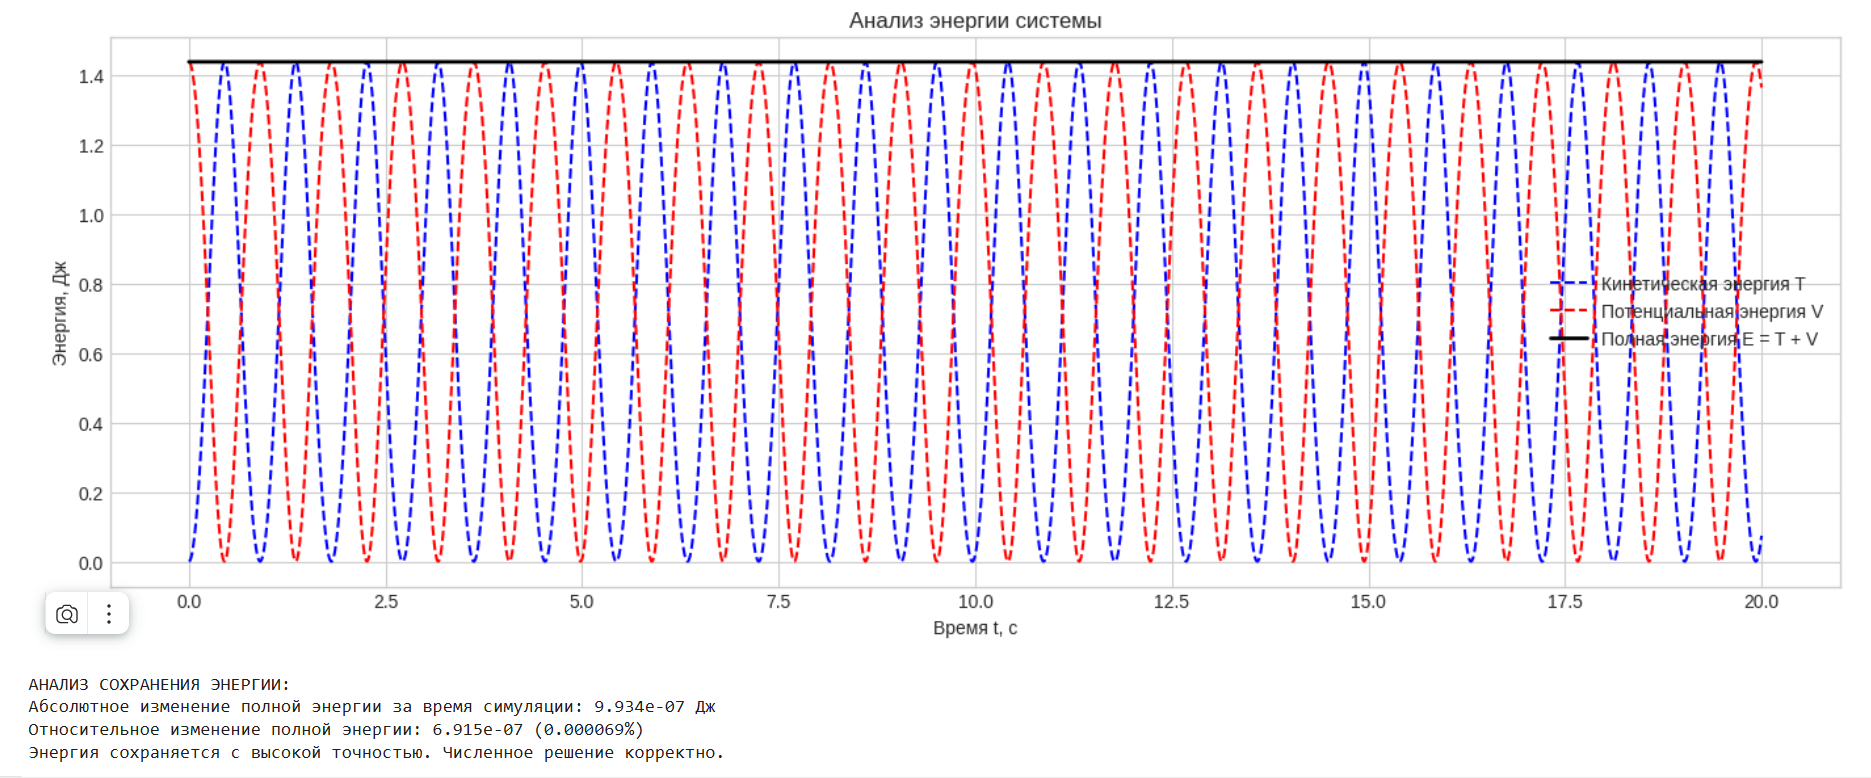

# Видео 6

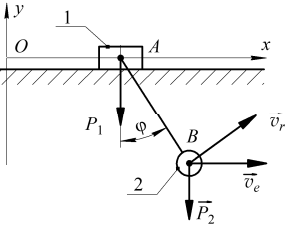

Найдите уравнение движения механизма (эллиптический маятник inverted pendulum on a cart) в общем виде, используя метод **Эйлера — Лагранжа**.

Сравните результат с заданием из прошлого видео.

Известны массы $m_{1,2}$. Трение отсутствует. Тело $B$ рассматривайте как математический маятник.

Результат представьте в виде пары формул $(\ddot{\phi}, \ddot{x})$.


*Подсказка:*


``` python
from sympy.physics.mechanics import init_vprinting
init_vprinting()
```
Позволит выводить формулы в читаемом виде (не $\frac{dx}{dt}$, а $\dot{x}$). Также это позволит более успешно дифференцировать (но иногда необходимо результат обрабатывать `sp.simplify`, `sp.expand`).



In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. символьное решение  ----------------------------------------------------------------------------------------------------------

# Объявление символов
t = sp.Symbol('t')
m1, m2, l, g, P1, P2 = sp.symbols('m1 m2 l g P1 P2')
x_sym = sp.Function('x')(t)
phi_sym = sp.Function('phi')(t)

# Производные
xdot = x_sym.diff(t)
phidot = phi_sym.diff(t)
xddot = x_sym.diff(t, 2)
phiddot = phi_sym.diff(t, 2)

# Кинетическая (T) и потенциальная (V) энергии
T = 0.5 * m1 * xdot**2 + 0.5 * m2 * (
    (xdot + l * phidot * sp.cos(phi_sym))**2 + (l * phidot * sp.sin(phi_sym))**2
)
V = m2 * g * l * (1 - sp.cos(phi_sym)) # Ноль энергии в нижнем положении

# Лагранжиан
L = T - V

# Уравнения Лагранжа
# d/dt(∂L/∂q̇) - ∂L/∂q = Q
eq1 = sp.Eq(sp.diff(sp.diff(L, xdot), t) - sp.diff(L, x_sym), P1)
eq2 = sp.Eq(sp.diff(sp.diff(L, phidot), t) - sp.diff(L, phi_sym), P2)

# Решаем систему уравнений относительно ускорений ẍ и φ̈
# Это ключевой шаг, автоматизирующий получение правильных формул
accel_solution = sp.solve([eq1, eq2], (xddot, phiddot))

# --- 2. числовое решение ---------------------------------------------------------------------------------------------------------------------------------

# Задаем параметры системы в виде словаря
params = {
    'm1': 1.0,   # масса тележки, кг
    'm2': 0.5,   # масса маятника, кг
    'l': 1.0,    # длина стержня, м
    'g': 9.81,   # ускорение свободного падения, м/с²
    'P1': 0.0,   # сила на тележку
    'P2': 0.0    # момент на маятник
}

# Создаем числовые функции из символьных выражений с помощью lambdify
vars_for_lambdify = [phi_sym, phidot, xdot]
param_subs = [(k, v) for k, v in params.items()]

xddot_func = sp.lambdify(vars_for_lambdify, accel_solution[xddot].subs(param_subs), 'numpy')
phiddot_func = sp.lambdify(vars_for_lambdify, accel_solution[phiddot].subs(param_subs), 'numpy')

def system_ode(t, state):
    """
    Система ОДУ для маятника на тележке.
    state = [x, x_dot, phi, phi_dot]
    """
    _, x_dot, phi, phi_dot = state

    # Вычисляем ускорения с помощью сгенерированных функций
    x_ddot = xddot_func(phi, phi_dot, x_dot)
    phi_ddot = phiddot_func(phi, phi_dot, x_dot)

    return [x_dot, x_ddot, phi_dot, phi_ddot]

# Начальные условия [x, ẋ, φ, φ̇]
initial_state = [0.0, 0.0, np.pi / 3, 0.0] # Угол 60 градусов

# Временной интервал для симуляции
t_span = (0, 15)
t_eval = np.linspace(*t_span, 1500)

# Решение системы ОДУ
solution = solve_ivp(
    system_ode, t_span, initial_state,
    t_eval=t_eval, method='RK45', dense_output=True, rtol=1e-8, atol=1e-8
)
t, y = solution.t, solution.y
x, x_dot, phi, phi_dot = y

# --- 3. построение графиков и выводы ----------------------------------------------------------------------------------------------------------------

print("РЕЗУЛЬТАТЫ ЧИСЛЕННОГО МОДЕЛИРОВАНИЯ")
print(f"Начальные условия: φ(0) = {initial_state[2]:.2f} рад, ẋ(0) = {initial_state[1]} м/с")


# Построение графиков
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
fig.suptitle('Динамика системы "Маятник на тележке"', fontsize=16)

# График 1: Координаты
axs[0, 0].plot(t, x, label='Позиция тележки x(t)')
axs[0, 0].plot(t, phi, label='Угол маятника φ(t)', color='orangered')
axs[0, 0].set_title('Положение и угол')
axs[0, 0].set_xlabel('Время, с')
axs[0, 0].set_ylabel('Позиция, м / Угол, рад')
axs[0, 0].legend()
axs[0, 0].grid(True)

# График 2: Скорости
axs[0, 1].plot(t, x_dot, label='Скорость тележки ẋ(t)')
axs[0, 1].plot(t, phi_dot, label='Угл. скорость маятника φ̇(t)', color='orangered')
axs[0, 1].set_title('Скорости')
axs[0, 1].set_xlabel('Время, с')
axs[0, 1].set_ylabel('Скорость, м/с или рад/с')
axs[0, 1].legend()
axs[0, 1].grid(True)

# График 3: Фазовый портрет маятника
axs[1, 0].plot(phi, phi_dot, color='darkviolet')
axs[1, 0].set_title('Фазовый портрет маятника')
axs[1, 0].set_xlabel('Угол φ, рад')
axs[1, 0].set_ylabel('Угловая скорость φ̇, рад/с')
axs[1, 0].grid(True)

# График 4: Энергия
T_sol = 0.5 * params['m1'] * x_dot**2 + 0.5 * params['m2'] * ((x_dot + params['l'] * phi_dot * np.cos(phi))**2 + (params['l'] * phi_dot * np.sin(phi))**2)
V_sol = params['m2'] * params['g'] * params['l'] * (1 - np.cos(phi))
E_total = T_sol + V_sol

axs[1, 1].plot(t, E_total, color='black', label='Полная энергия E')
axs[1, 1].set_title('Проверка сохранения энергии')
axs[1, 1].set_xlabel('Время, с')
axs[1, 1].set_ylabel('Энергия, Дж')
axs[1, 1].grid(True)
# Добавим текст о сохранении энергии
energy_variation = np.max(E_total) - np.min(E_total)
axs[1, 1].text(0.95, 0.05, f'ΔE ≈ {energy_variation:.2e} Дж', transform=axs[1, 1].transAxes, ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

plt.show()

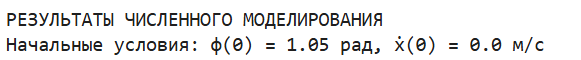
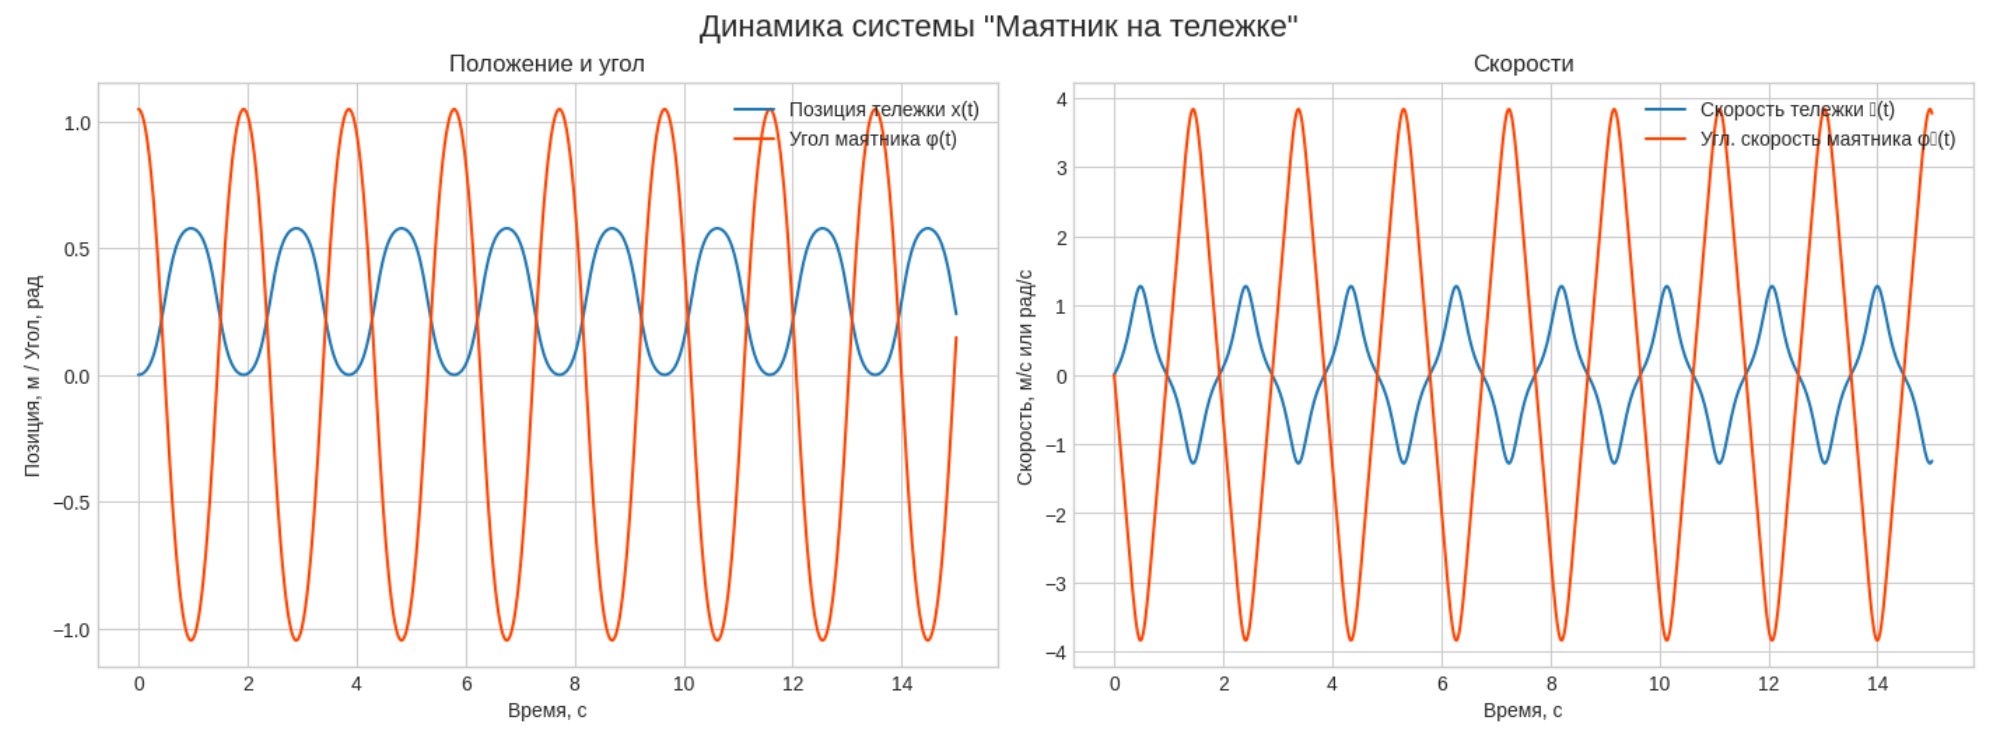
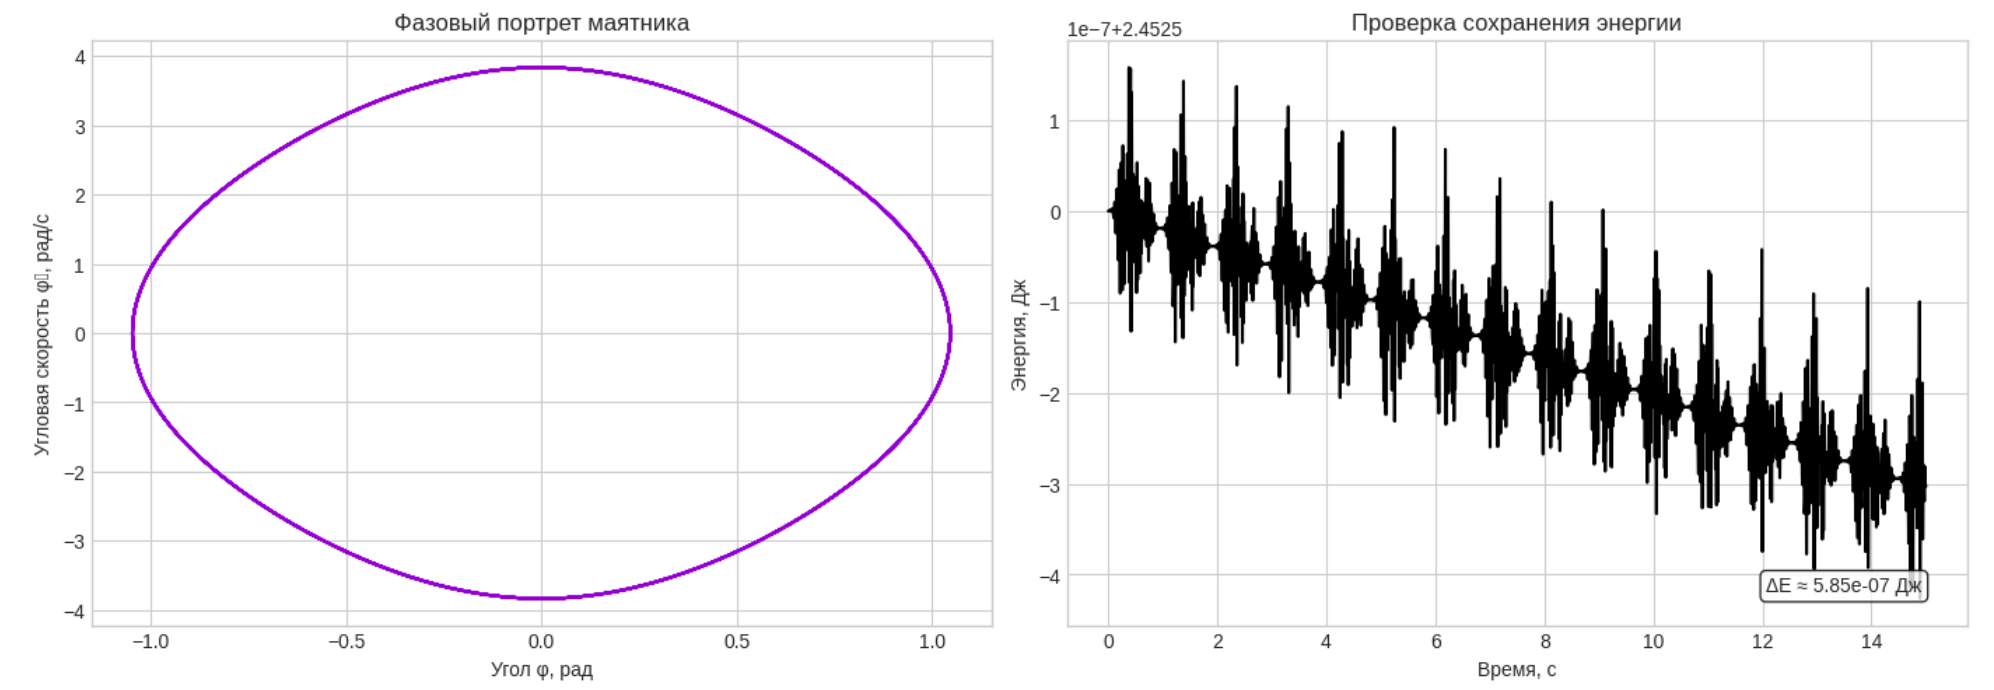